In [15]:
# Dependancies 

import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

In [16]:
# Class for DESeq2 analysis

class deseq2_analysis_class:

    def __init__(self, gene_counts: pd.DataFrame, metadata: pd.DataFrame):

        """ 
        Constructs the appropriate dataframe to carry out DESeq2 analysis and create plots
        """

        self.gene_counts = self.construct_dataframe(gene_counts)
        self.metadata = metadata
        self.deseq_results = None
        

    def construct_dataframe(self, df:pd.DataFrame) -> pd.DataFrame:

        """
        Prepare the RNA counts DataFrame by rounding and converting to integers.
        """
        df = df.round()
        return df.astype(int)
        

    def perform_deseq2(self, metadata_column: str, group_1: str, group_2: str) -> pd.DataFrame:
        
        """
        Perform DESeq2 differential expression analysis.
        """
        
        merged_df = self.gene_counts.merge(self.metadata, left_index=True, right_index=True, how='inner')
        count_data = merged_df.drop(columns=[metadata_column])
        metadata = merged_df[[metadata_column]]

        dds = DeseqDataSet(
            counts=count_data,
            metadata=metadata,
            design_factors=metadata_column,
            refit_cooks=True,
        )
        dds.deseq2()

        stat_res = DeseqStats(dds, contrast=[metadata_column, group_1, group_2])
        stat_res.summary()

        results_df = stat_res.results_df.dropna(subset=['padj']).sort_values(by='padj')
        self.deseq_results = results_df
        return results_df

        
    def volcano_plot(self, top_n: int = 20):
        
        """
        Generate a volcano plot from DESeq2 results.
        """
        
        if self.deseq_results is None:
            raise ValueError("You must run perform_deseq2() before plotting.")

        df = self.deseq_results.copy()
        df['Gene_name'] = df.index

        df['significance'] = 'Not Significant'
        df.loc[(df['padj'] < 0.05) & (df['log2FoldChange'] > 1), 'significance'] = 'Upregulated'
        df.loc[(df['padj'] < 0.05) & (df['log2FoldChange'] < -1), 'significance'] = 'Downregulated'

        top_genes = df.dropna(subset=['padj', 'Gene_name']).nsmallest(top_n, 'padj')

        volc_fig = plt.figure(figsize=(12, 8))
        sns.scatterplot(
            data=df,
            x='log2FoldChange',
            y=-np.log10(df['padj']),
            hue='significance',
            palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'},
            alpha=0.7,
            edgecolor=None
        )

        plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
        plt.axvline(1, color='red', linestyle='--', linewidth=1)
        plt.axvline(-1, color='blue', linestyle='--', linewidth=1)

        texts = []
        for _, row in top_genes.iterrows():
            text = plt.text(
                row['log2FoldChange'],
                -np.log10(row['padj']),
                row['Gene_name'],
                fontsize=8,
                ha='right' if row['log2FoldChange'] < 0 else 'left',
                va='bottom',
                color='black'
            )
            texts.append(text)
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

        plt.title('Volcano Plot with Top {} Most Significant Genes'.format(top_n))
        plt.xlabel('log2(Fold Change)')
        plt.ylabel('-log10(Adjusted p-value)')
        plt.legend(title='Gene Regulation', loc='upper right')
        plt.xlim(-10, 10)
        plt.tight_layout()

        return volc_fig
        

    def plot_violin(self, gene: str = "EGFR", metadata_column: str = "EGFR_mutation"):
        
        """
        Plot a violin plot showing the expression of a given gene
        across different groups in the metadata.
        """
        
        if gene not in self.gene_counts.columns:
            raise ValueError(f"Gene '{gene}' not found in gene_counts.")

        # Merge gene expression and metadata
        expr = self.gene_counts[[gene]]
        expr[metadata_column] = self.metadata[metadata_column]

        # Plot
        vio_fig = plt.figure(figsize=(8, 5))
        sns.violinplot(x=metadata_column, y=gene, data=expr, palette="Set2", inner="box")
        plt.title(f"Expression of {gene} by {metadata_column}")
        plt.xlabel(metadata_column)
        plt.ylabel("Normalized Counts")
        plt.tight_layout()

        return vio_fig


    def plot_pca(self, metadata_column: str = "EGFR_mutation"):
        
        """
        Generate a PCA plot colored by a metadata column (e.g. EGFR mutation status).
        """
    
        # Scale and apply PCA
        X = self.gene_counts.values
        X_scaled = StandardScaler().fit_transform(X)
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(X_scaled)

        # Construct PCA DataFrame
        pca_df = pd.DataFrame(pcs, columns=["PC1", "PC2"], index=self.gene_counts.index)
        pca_df[metadata_column] = self.metadata[metadata_column]

        # Plot
        pca_fig = plt.figure(figsize=(8, 6))
        sns.scatterplot(
        x="PC1", y="PC2",
        hue=metadata_column,
        data=pca_df,
        palette="Set1",
        s=80,
        edgecolor="k"
        )
        plt.title(f"PCA of Samples Colored by {metadata_column}")
        plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
        plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
        plt.legend(title=metadata_column)
        plt.tight_layout()

        return pca_fig


    def plot_umap_basic(self, n_top_genes=1000):
        
        """
        Basic UMAP (works with genes-as-rows)
        """
        
        # Transpose internally for UMAP only
        X = self.gene_counts.T  # samples x genes
        
        # Select top genes from transposed data
        top_genes = X.var().nlargest(n_top_genes).index
        X_top = X[top_genes]
        
        # Scale and UMAP
        X_scaled = StandardScaler().fit_transform(X_top)
        embedding = umap.UMAP(random_state=42).fit_transform(X_scaled)
        
        # Plot
        plt.figure(figsize=(8, 6))
        plt.scatter(embedding[:, 0], embedding[:, 1], s=20)
        plt.title(f"UMAP (Top {n_top_genes} Genes)")
        plt.xlabel("UMAP1")
        plt.ylabel("UMAP2")
        plt.tight_layout()
        return plt.gcf()
    
    def plot_umap_colored(self, metadata_column='EGFR_mutation', n_top_genes=1000):
        
        """
        Fixed colored UMAP with proper sample alignment
        """
        
        # 1. Transpose to samples x genes (like plot_umap_basic)
        X = self.gene_counts.T  # Samples become rows
        
        # 2. Find overlapping samples with metadata
        common_samples = X.index.intersection(self.metadata.index)

        print(common_samples)
        
        if not common_samples:
            # Diagnostic output
            print("First 5 samples in gene counts:", X.index[:5].tolist())
            print("First 5 samples in metadata:", self.metadata.index[:5].tolist())
            print("Are there any matches?", bool(set(X.index) & set(self.metadata.index)))
            raise ValueError(f"No overlapping samples. Gene counts has {len(X)} samples, metadata has {len(self.metadata)}")
        
        # 3. Subset data to common samples
        X = X.loc[common_samples]
        metadata = self.metadata.loc[common_samples, metadata_column]
        
        # 4. Select top variable genes
        top_genes = X.var().nlargest(n_top_genes).index
        X_top = X[top_genes]
        
        # 5. UMAP
        reducer = umap.UMAP(random_state=42)
        embedding = reducer.fit_transform(StandardScaler().fit_transform(X_top))
        
        # 6. Plot
        plot_df = pd.DataFrame({
            "UMAP1": embedding[:, 0],
            "UMAP2": embedding[:, 1],
            metadata_column: metadata
        })
        
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=plot_df,
            x="UMAP1",
            y="UMAP2",
            hue=metadata_column,
            palette="Set1",
            s=80,
            alpha=0.8
        )
        plt.title(f"UMAP - {len(common_samples)} Samples")
        return plt.gcf()
            



In [17]:
# Load in data

gene_counts = pd.read_csv("data/data_mrna_seq_v2_rsem.txt", sep='\t')

whole_cohort_meta = pd.read_csv("data/EGFR_whole_cohort.csv")


In [18]:
# Whole_cohort_meta data fixing

## Remove unnamed column
whole_cohort_meta = whole_cohort_meta.drop(["Unnamed: 0"], axis = 1)

## setsubmitter_id_samples as the index
whole_cohort_meta.set_index('submitter_id.samples', inplace=True)

whole_cohort_meta


,EGFR_mutation
submitter_id.samples,
TCGA-62-A46Y-01A,negative
TCGA-55-7903-01A,negative
TCGA-55-7903-11A,negative
TCGA-97-8179-01A,negative
TCGA-55-6982-01A,negative
...,...
TCGA-91-8496-01A,negative
TCGA-91-8496-11A,negative
TCGA-44-A47B-01A,negative


In [19]:
# Fix counts data

## Remove entrex gene id
gene_counts = gene_counts.drop(['Entrez_Gene_Id'], axis=1)

## Set index to Hugo_Symbol
gene_counts.set_index('Hugo_Symbol', inplace=True)

## Transpose gene counts
gene_counts = gene_counts.T

## Add trailing A to the end of the index in order to merge properly
gene_counts.index = [id + 'A' for id in gene_counts.index]

#make column names unique by dropping duplicate columns (for now)
##can you think of another way? take the mean of the duplicates? maybe treat each as a separate gene by adding a suffix?
gene_counts = gene_counts.loc[:, ~gene_counts.columns.duplicated()]


In [20]:
# Initialize the class with gene counts and metadata
analysis = deseq2_analysis_class(gene_counts=gene_counts, metadata=whole_cohort_meta)

# Run DESeq2 analysis
results = analysis.perform_deseq2(
    metadata_column='EGFR_mutation',
    group_1='positive',
    group_2='negative'
)



C:\Users\judeh\anaconda3\envs\lung_cancer\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\judeh\AppData\Local\Temp\ipykernel_7748\1506186011.py:35: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.61 seconds.

Fitting dispersions...
... done in 13.10 seconds.

Fitting dispersion trend curve...
... done in 1.36 seconds.

Fitting MAP dispersions...
... done in 13.25 seconds.

Fitting LFCs...
... done in 6.58 seconds.

Calculating cook's distance...
... done in 0.96 seconds.

Replacing 2403 outlier genes.

Fitting dispersions...
... done in 1.74 seconds.

Fitting MAP dispersions...
... done in 2.10 seconds.

Fitting LFCs...
... done in 1.17 seconds.

Running Wald tests...
... done in 3.16 seconds.



Log2 fold change & Wald test p-value: EGFR_mutation positive vs negative
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
LOC100130426     0.007161       -0.043878  5.600810 -0.007834  0.993749   
UBE2Q2P3        13.223956        0.653613  0.265478  2.462022  0.013816   
HMGB1P1        107.185469       -0.110551  0.118180 -0.935444  0.349560   
TIMM23         918.064574       -0.286331  0.120477 -2.376639  0.017471   
MOXD2            0.000000             NaN       NaN       NaN       NaN   
...                   ...             ...       ...       ...       ...   
ZYX           4036.399442       -0.074744  0.154612 -0.483427  0.628792   
FLJ10821      1082.657233        0.059648  0.126310  0.472232  0.636761   
ZZZ3           704.590071       -0.275249  0.118485 -2.323067  0.020176   
TPTEP1         136.643942       -1.735635  0.477103 -3.637865  0.000275   
AKR1C6P          0.081308       -0.271072  2.066902 -0.131149  0.895658   

                  padj  
L

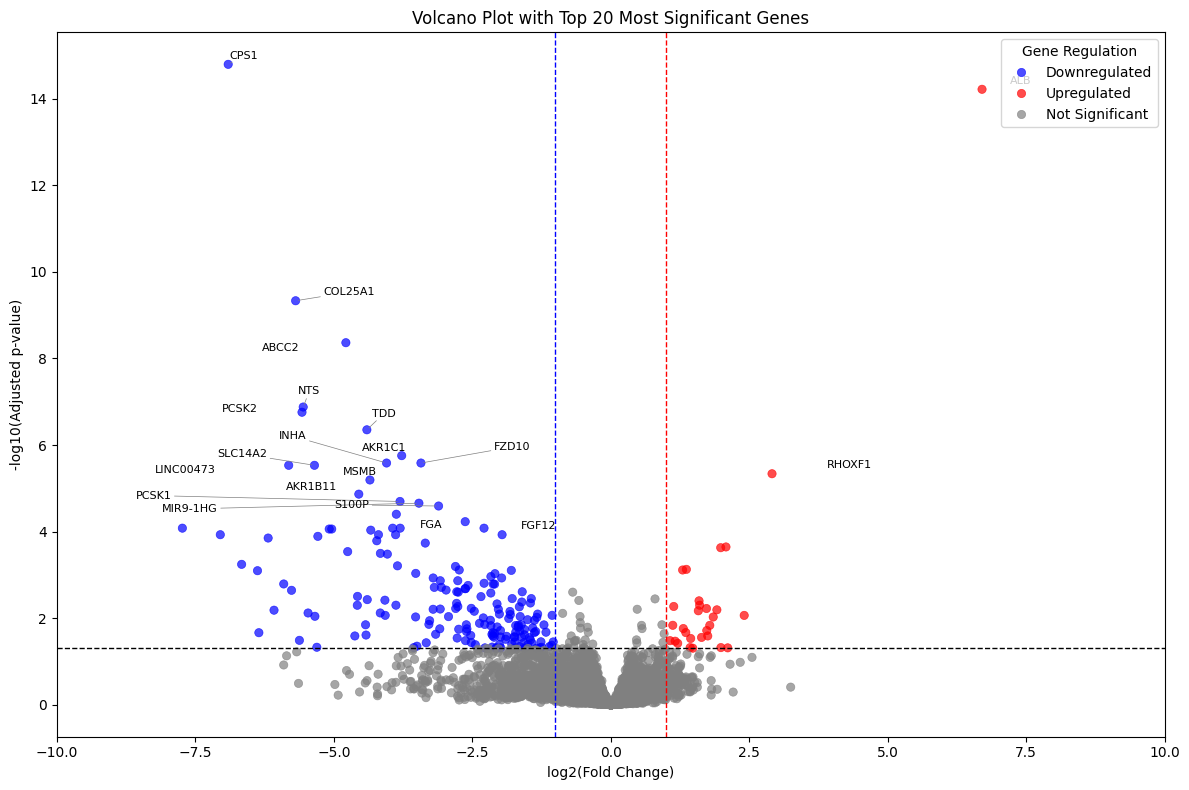

In [21]:
# Display plots

## Display the volcano plot
volcano_fig = analysis.volcano_plot()



C:\Users\judeh\AppData\Local\Temp\ipykernel_7748\1506186011.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expr[metadata_column] = self.metadata[metadata_column]


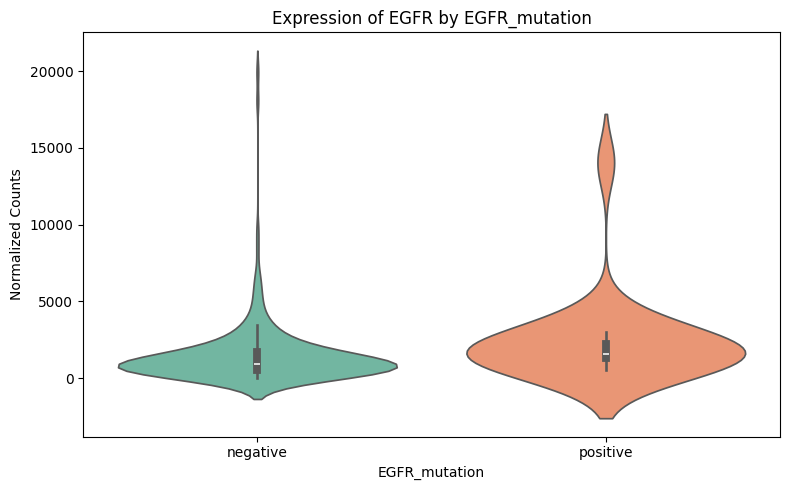

In [22]:
# Display plots

## Display Violin plot
violin_figure = analysis.plot_violin()



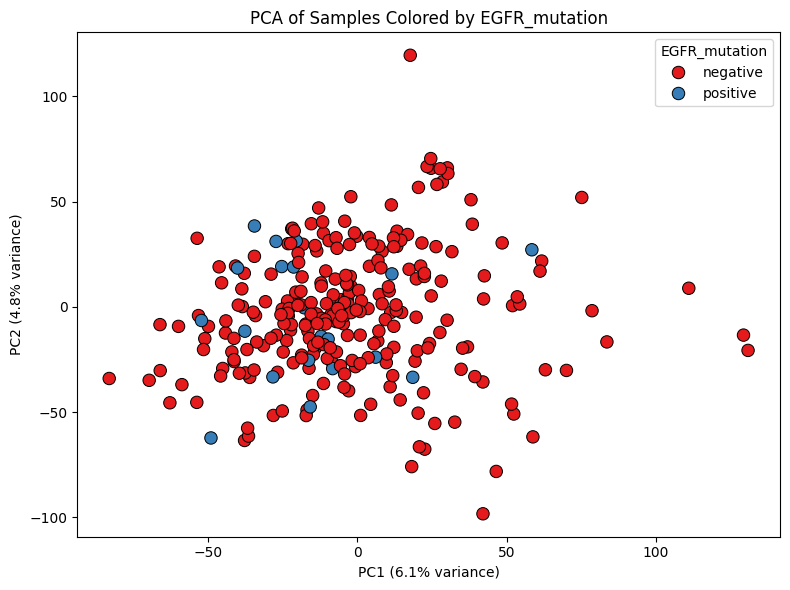

In [23]:
# Display plots

## Display PCA
pca_figure = analysis.plot_pca()


C:\Users\judeh\anaconda3\envs\lung_cancer\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


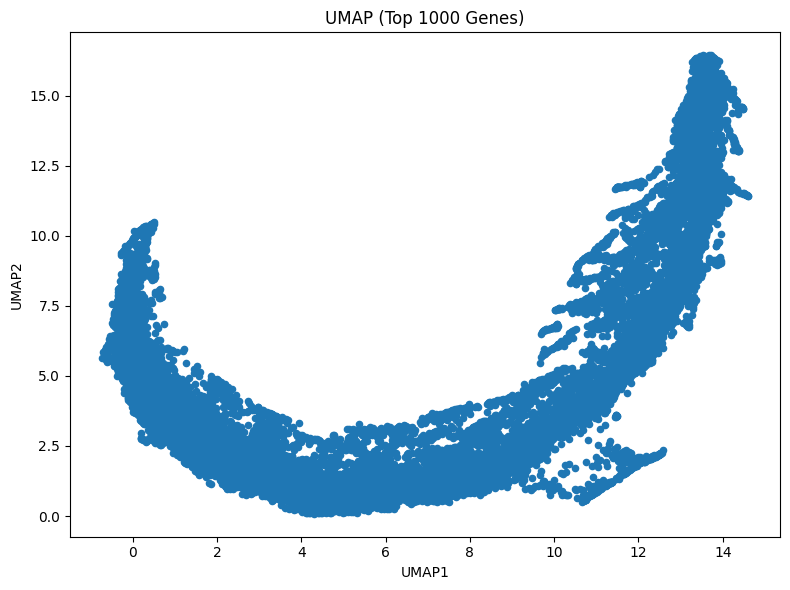

In [24]:
# Display plots

## Display UMAP
umap_figure = analysis.plot_umap_basic()

In [26]:
# Should work without affecting other methods

umap_graph = analysis.plot_umap_colored()


Index([], dtype='object')


ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().